# Visualization of the latent space

In [42]:
print('hello')

hello


## Imports

In [43]:
import ipywidgets as widgets
from IPython.display import display
from matplotlib import pyplot as plt 
import numpy as np
import json
import os
import sys
from glob import glob
from pathlib import Path
#from attrdict import AttrDict
from matplotlib import pyplot as plt
import numpy as np
import pickle
import imageio
from scipy import ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F


from ipywidgets import interactive, fixed
import collections
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.Sequence = collections.abc.Sequence
collections.MutableSet = collections.abc.MutableSet

%matplotlib ipympl

In [44]:
print(os.getcwd())

/home/goetzkeg/git/betaVAEDemo


In [45]:
from configs import parse_configuration_yaml
from evaluation import get_trained_model
from datasets.gmd_charge_labels_seeded_dataset import GMDChargeLabelsSeededDataset

## Definitions

In [46]:
config_dir = '../configs/'
flare = False

config_names = ['x017.yaml'] #'n23ov001.yaml']#[os.path.join(config_dir,'pc{:03d}'.format(i),'pc{:03d}.json'.format(i)) for i in model_nr]

if flare:
    pass
    #config_names = [ 'n23ov002.yaml']

config_files = [config_dir + cn for cn in config_names]

input_im = './data/test_dataWidgets.npy'

n_slider = 10
min_slider = -3.5
max_slider = 3.5
step_slider = 0.1

def adapt_cponfig(config):
    config['callbacks']['checkpoint_time']['dirpath'] = './checkpoints/' 
    
    return config

# load images, models... 

In [47]:
# load images
im_arr = np.load(input_im)/255.
im_dict = {'Im{:02d}'.format(n): im_arr[n] for n in range(im_arr.shape[0])}


#load models
model_dict = {}
for config_name, config_file in zip(config_names,config_files):
    config = parse_configuration_yaml(config_file)
    config = adapt_cponfig(config)
    model = get_trained_model(config, device = 'cpu', rootpath_config='./')
    model.train_bool = False
    model_name = config_name.split('.')[0]
    model_dict[model_name] = model


Lightning automatically upgraded your loaded checkpoint from v1.8.1 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint checkpoints/x017/last.ckpt`


# Visualization

### Define interactive elements





In [48]:
dropdownModel = widgets.Dropdown(
    options=list(model_dict.keys()),
    value=list(model_dict.keys())[0],
    description='Model:',
)


dropdownImage = widgets.Dropdown(
    value = list(im_dict.keys())[0],
    options=list(im_dict.keys()),
    description='Image:',
)

z_slider_list = [
     widgets.FloatSlider(
        value=0,
        min=min_slider,
        max=max_slider,
        step=step_slider,
        description=f'$z_{{{n}}}$',
        orientation='vertical',
        layout=widgets.Layout(height ='90%')
    )
    for n in range(n_slider)

]

labellist = []
labellist.append(widgets.Text(f'$z_{0}$: reconstruction/ electron distribution'))
labellist.append(widgets.Text(f'$z_{1}$: y coordinate'))
labellist.append(widgets.Text(f'$z_{2}$: lasing'))
labellist.append(widgets.Text(f'$z_{3}$: reconstruction/ electron distribution'))
labellist.append(widgets.Text(f'$z_{4}$: electron pulse length'))
labellist.append(widgets.Text(f'$z_{5}$: electron energy drop near head'))
labellist.append(widgets.Text(f'$z_{6}$: intensity in head'))
labellist.append(widgets.Text(f'$z_{7}$: electron pulse length'))
labellist.append(widgets.Text(f'$z_{8}$: reconstruction/ electron distribution'))
labellist.append(widgets.Text(f'$z_{9}$: electron pulse length and chirp'))





resizeCBButton = widgets.Button(description = 'resize Cbar')

resetzButton = widgets.Button(description = 'z to zero')

ztoImButton = widgets.Button(description = 'z to Im')

loffButton = widgets.Button(description = 'z2 to 1.9')


debugText = widgets.Text(
    value='Hello World',
    description='Status:',
    disabled=False   
)

### define and link watch functions

In [49]:

def update_reconstruction(change):
    if debugText.value == 'load Image':
        pass
    else:
        decoder = model_dict[dropdownModel.value].decoder

        values = [slider.value for slider in z_slider_list]
        z = torch.tensor(values)[None, :].detach().cpu()
        y = decoder(z).detach()[0,0].numpy()
        imobj.set_array(y)


        image_str = dropdownImage.value
        new_image = im_dict[image_str]    
        try:
            diff_image = new_image/np.sum(new_image)   -y/np.sum(y)
            diffobj.set_array(diff_image)
            vmax = max(np.abs(np.min(diff_image)), np.max(diff_image))
            diffobj.set_clim([-vmax, vmax])
        except ValueError as ve:
            print('WARNING, example data and model does not match!')
            print(ve)
            debugText.value = 'WARNING, example data and model does not match!'

for z_slider in z_slider_list:    
    z_slider.observe(update_reconstruction, names='value')
    
dropdownModel.observe(update_reconstruction)    
    

def resizeCB(change):
    new_img = imobj.get_array()
    imobj.set_clim([new_img.min(), new_img.max()])    
    
resizeCBButton.on_click(resizeCB)


    
def load_image(change):
    image_str = dropdownImage.value
    debugText.value = 'load Image'
    new_image = im_dict[image_str]                      
    dataobj.set_array(new_image)
    dataobj.set_clim([new_image.min(), new_image.max()])
    
    try:
        encoder = model_dict[dropdownModel.value].encoder
        with torch.no_grad():
            encoder.train_bool = False
            z = encoder(torch.tensor(new_image[None,], dtype = torch.float32))[0]
            if not encoder.train_bool:
                z = z[0]
        z = z.numpy()
        for z_value,z_slider in zip(z,z_slider_list):    
            z_slider.value = z_value
        debugText.value = 'ready'
    except RuntimeError as re:
        print('WARNING, example data and model does not match!')
        print(re)
        debugText.value = 'WARNING, example data and model does not match!'
            
    
dropdownImage.observe(load_image)
ztoImButton.on_click(load_image)

def reset_z(change):    
    for z_slider in z_slider_list:    
        z_slider.value = 0
        
def z2to2(change):    
    debugText.value = 'z2'
    for i,z_slider in enumerate(z_slider_list): 
        if i == 2:
            z_slider.value = 1.9
    #resizeCB(0)
        
resetzButton.on_click(reset_z)
loffButton.on_click(z2to2)

### plot and display

Text(value='Hello World', description='Status:')

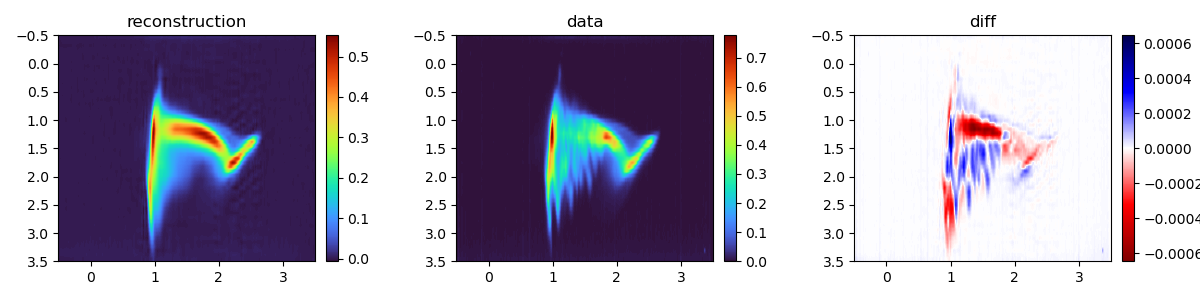

In [50]:

plt.close('all')
fig, ax = plt.subplots(1,3, num = 'such a nice figure', dpi=100, figsize=[12,3])
imobj = ax[0].imshow((np.random.randn(4,4)), cmap = 'turbo', aspect = 'auto')
ax[0].set_title('reconstruction')
cbobj = plt.colorbar(imobj,fraction=0.046, pad=0.04)

dataobj = ax[1].imshow((np.zeros((4,4))), cmap = 'turbo', aspect = 'auto')
cbobjdata = plt.colorbar(dataobj,fraction=0.046, pad=0.04)
ax[1].set_title('data')
plt.tight_layout()


diffobj = ax[2].imshow((np.zeros((4,4))), cmap = 'seismic_r', vmin = -1, vmax = 1, aspect = 'auto')
cbobjdiff = plt.colorbar(diffobj,fraction=0.046, pad=0.04)
ax[2].set_title('diff')
plt.tight_layout()



optionsbox = widgets.HBox([resizeCBButton, resetzButton, ztoImButton, loffButton, dropdownModel, dropdownImage])





if n_slider==20:
    sliderbox0 = widgets.HBox(z_slider_list[:10])
    sliderbox1 = widgets.HBox(z_slider_list[10:])
    display(sliderbox0,sliderbox1, optionsbox)

else:
    sliderbox = widgets.HBox(z_slider_list)
    labelbox = widgets.VBox(labellist)
    combined_box = widgets.HBox([sliderbox, labelbox])
    display(combined_box, optionsbox, debugText)

update_reconstruction(None)
load_image(None)
resizeCB(None)